In [2]:

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import coordinates as coords
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.simbad import Simbad
from astroquery.sdss import SDSS
from sdss import Region
from sdss import Region
import sdss
import os     #importing some python modules


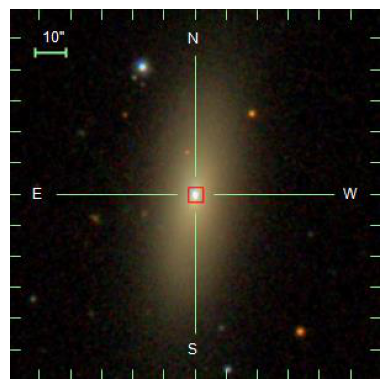

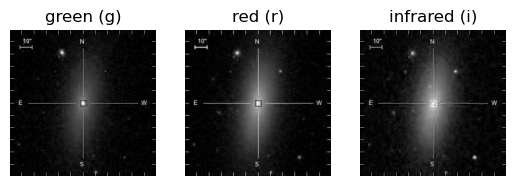

In [3]:
# https://skyserver.sdss.org/dr18/VisualTools/navi
galaxy_name = 'IC 976'
galaxy = SkyCoord.from_name(galaxy_name)
pos = coords.SkyCoord(galaxy.ra, galaxy.dec, frame='icrs')
ra = 212.180359879211#210.08384725
dec = -1.16162989692128 #38.91540956
reg = Region(ra, dec, fov=0.033)
reg.show()
reg.show3b()

由上图可知，此星系为S0星系，没有明显的漩涡结构与棒结构，但有较为明显的核球。

In [16]:
result = SDSS.query_crossid(pos, photoobj_fields=['modelMag_u', 'modelMag_g', 'modelMag_r','modelMag_i',
                                                  'modelMag_z'])
print(result[0])

obj_id        objID        modelMag_u modelMag_g modelMag_r modelMag_i modelMag_z       obj_id1        type 
------ ------------------- ---------- ---------- ---------- ---------- ---------- ------------------- ------
 obj_0 1237648702979047550   15.11673   13.58337   12.98458   12.70121   12.51614 1237648702979047550 GALAXY


/data/public/mc/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


u, g较大：年轻星较多；i小：年老星较少

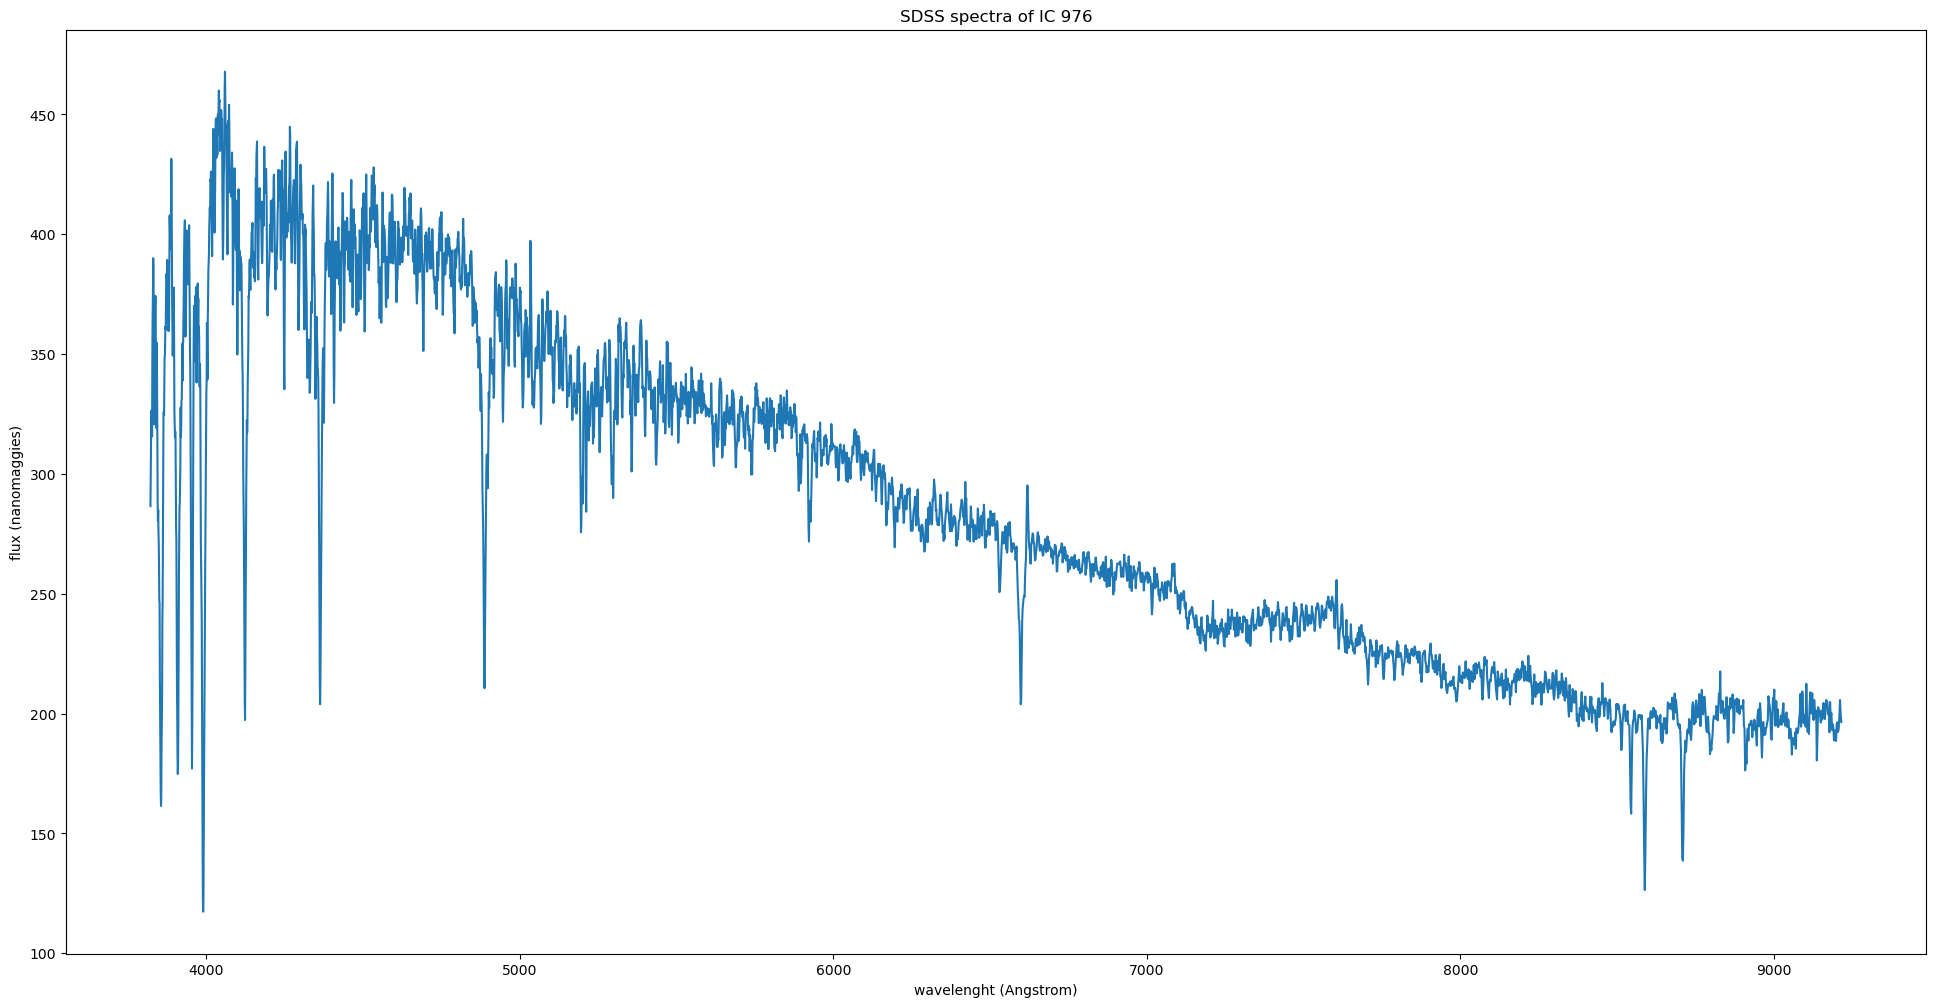

In [42]:


spectra = SDSS.get_spectra(matches=xid)
spectra_data = spectra[0][1].data
plt.figure(figsize=(24, 12))
plt.plot(10**spectra_data['loglam'], spectra_data['flux'])
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectra of '+galaxy_name)
plt.show()

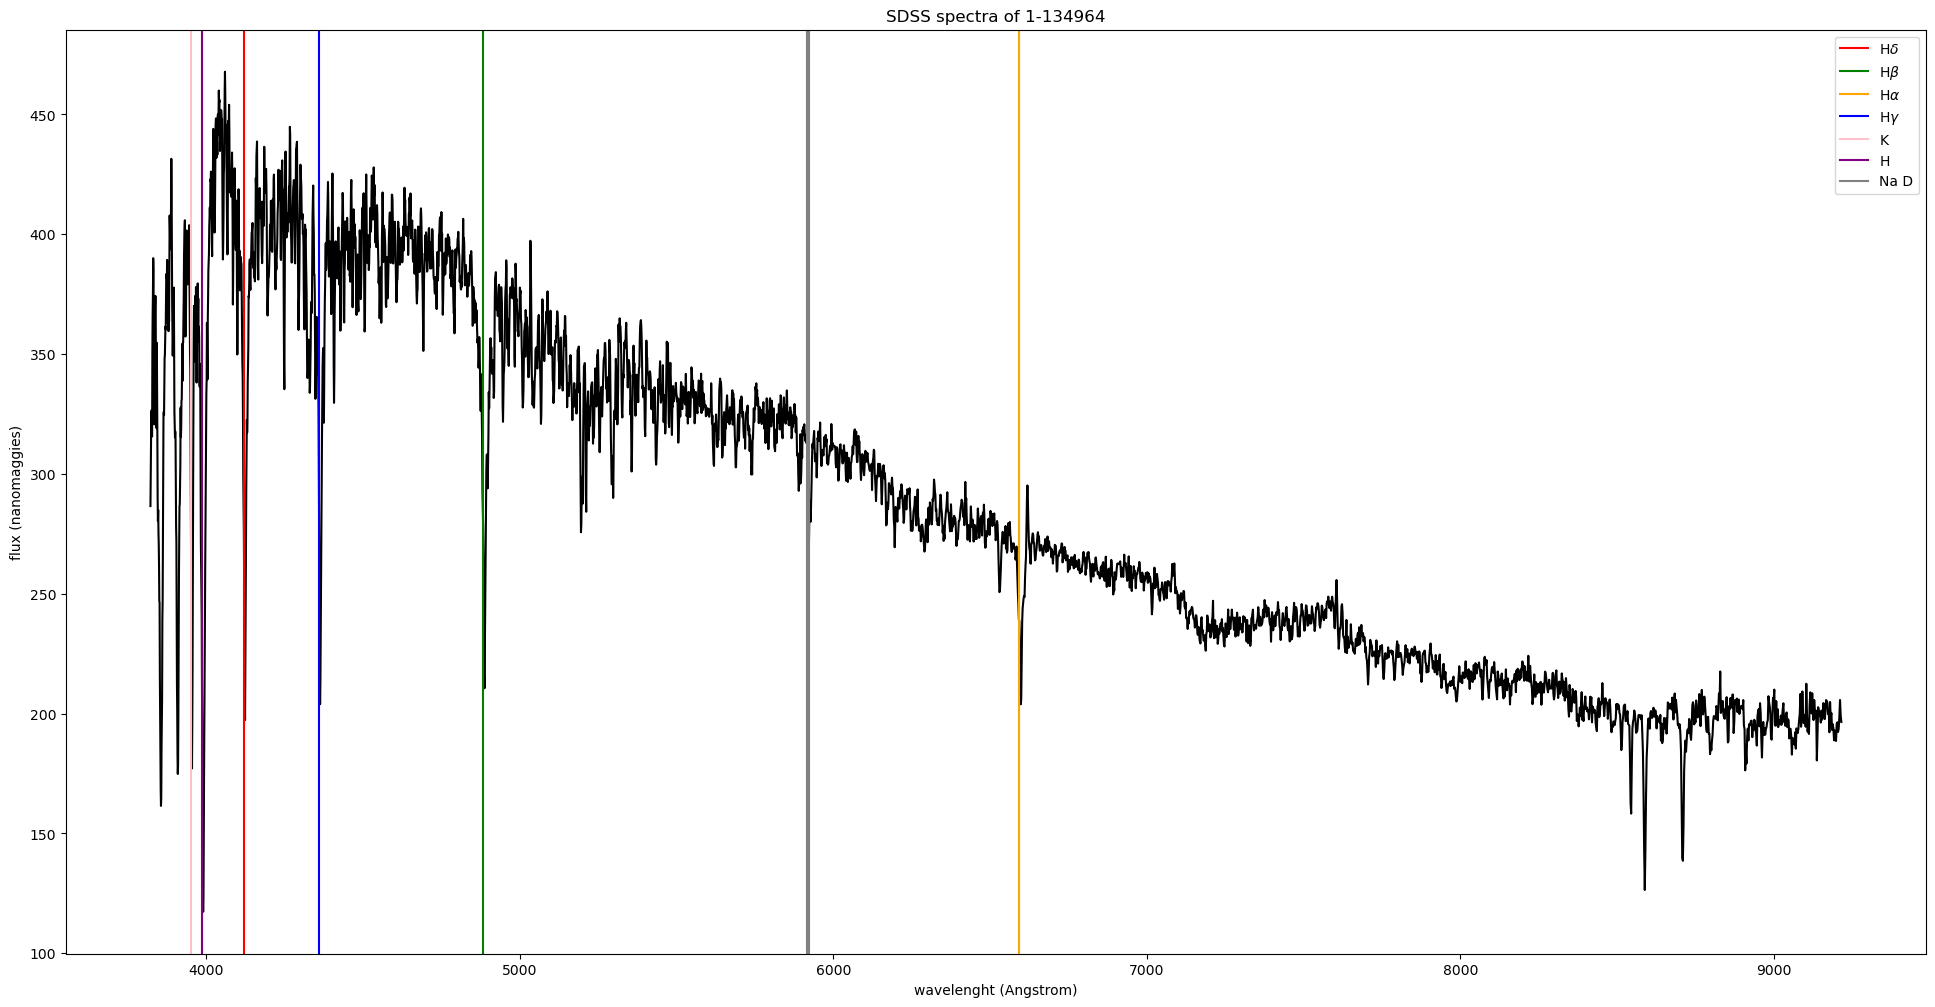

In [52]:
lines = spectra[0][3].data
redshift = 0.004153
plt.figure(figsize=(24, 12))
plt.plot(10**spectra_data['loglam'], spectra_data['flux'], color='black')
# plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_I] 6300'], label=r'O[II]', color='blue')
# plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_delta'] * (1+redshift), label=r'H$\delta$', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_beta']*(1+redshift), label=r'H$\beta$', color='green')
# plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='He_II 4650'], label=r'H$\alpha$', color='green')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_alpha']*(1+redshift), label=r'H$\alpha$', color='orange')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_gamma']*(1+redshift), label=r'H$\gamma$', color='blue')

# plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[S_II] 6716'], label=r'H$\alpha$', color='green')
plt.axvline(x=3934.777*(1+redshift), label=r'K', color='pink')
plt.axvline(x=3969.588*(1+redshift), label=r'H', color='purple')
plt.axvline(x=5891.58*(1+redshift), label=r'Na D', color='grey')
plt.axvline(x=5897.56*(1+redshift), color='grey')
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectra of '+str("1-134964"))
plt.legend()
# print(lines)
# https://classic.sdss.org/dr6/algorithms/linestable.html 

由上图可知，此星系的光谱连续谱阶段，在4000埃左右到达峰值，并逐渐下落。因此可以判断，此星系为以A型星为主导的后星爆星系。从4000埃的截断来看，此星系具有大量的年轻恒星。虽然大部分后星爆星系由主并合主导并含有AGN反馈，但在公开的AGN catalog中并没有查询到对应的射电源，且星系光谱中并未发现明显的H_alpha发射线，因此初步判断此星系的中心并非AGN，且星爆是由于大质量气体内流产生，亮核也是有大量恒星形成的地区。

较强的K,H可用于证认红移，NaD吸收线存在但不强，证明老年恒星虽然存在，但并不占据主导。

In [53]:
b = 10**spectra_data['loglam']
up = np.where((b> 4000) & (b<4100))
down = np.where((b> 3850) & (b<4161))

dy_index1 = np.where((b> 4041.6) & (b<4079.75))
dy_index2 = np.where((b> 4128.5) & (b<4161))
dy = np.concatenate((spectra_data['flux'][dy_index1], 
                   spectra_data['flux'][dy_index2]))

y = spectra_data['flux'][np.where((b> 4083.5) & (b<4122.25))]
dx = b[np.where((b> 4083.5) & (b<4122.25))]

abs = 0
for i in np.arange((len(dx)-1)):
  abs+=(dx[i+1]-dx[i])*(1-(y[i]/(np.sum(dy)/(dx[i]-dx[0]))))

Dn_4000 = (np.sum(spectra_data['flux'][up])/np.sum(spectra_data['flux'][down]))
print("Dn_4000 = ", Dn_4000)
print("H_delta = ", abs)


Dn_4000 =  0.37380382
H_delta =  29.58517193712919


/tmp/ipykernel_3240427/209279376.py:15: RuntimeWarning: divide by zero encountered in float_scalars
  abs+=(dx[i+1]-dx[i])*(1-(y[i]/(np.sum(dy)/(dx[i]-dx[0]))))


In [57]:
df_obj = reg.nearest_objects()
df_sp = reg.nearest_spects()

print(df_sp)

                 objID           specObjID  distance         ra       dec  \
0  1237648702979047550  340044889930622976  0.001879  212.18034 -1.161654   

  class subClass         u         g         r         i         z  redshift  \
0  STAR       A0  15.11673  13.58337  12.98458  12.70121  12.51614  0.004153   

   zErr zWarning  
0  -1.0       16  


无近邻星系

In [60]:
# http://www.astro.gsu.edu/AGNmass/exclude.php

![cluster.png](cluster.jpg)

http://www.atlasoftheuniverse.com/galgrps/viriii.html

此星系位于Virgo III Groups的NGC 5506 GROUP中，为group星系，平均距离为85 million ly， size为1.5'，RV 为1794 km/s。
表面亮度为23.61 mag/arcsec2

![d4000.png](d4000.png)

![SED.jpg](SED.jpg)

SED拟合也充分证明了是一个以年轻星族为主导的后星爆星系，并根据有大量气体内流，判断其应有较为丰富的尘埃成分。